In [1]:
import os
import glob
import pickle
import numpy as np
from scipy import io
from mne import viz, stats
from matplotlib import colors, gridspec, pyplot as plt

In [2]:
CAF_DOSE = 200
SIGNIFICANT_P = 0.05

PROJECT_PATH = '..\\data' # path to where the EEG sensor position file is stored
RESULTS_PATH = '..\\results'
FIGURE_PATH = '..\\figures'

STAGES = ['AWSL', 'NREM', 'REM']
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'low gamma']
CHANNELS = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'P3 ', 'P4',
            'O1', 'O2 ', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']

In [3]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
glob.glob(os.path.join(RESULTS_PATH, f'scores_single{CAF_DOSE}', f'scores*.pickle'))

scores = {}
for path in glob.glob(os.path.join(RESULTS_PATH, f'scores_single{CAF_DOSE}', f'scores*.pickle')):
    clf = path.split(os.sep)[-1].split('.')[0].split('_')[-1]
    with open(path, 'rb') as file:
        scores[clf] = pickle.load(file)

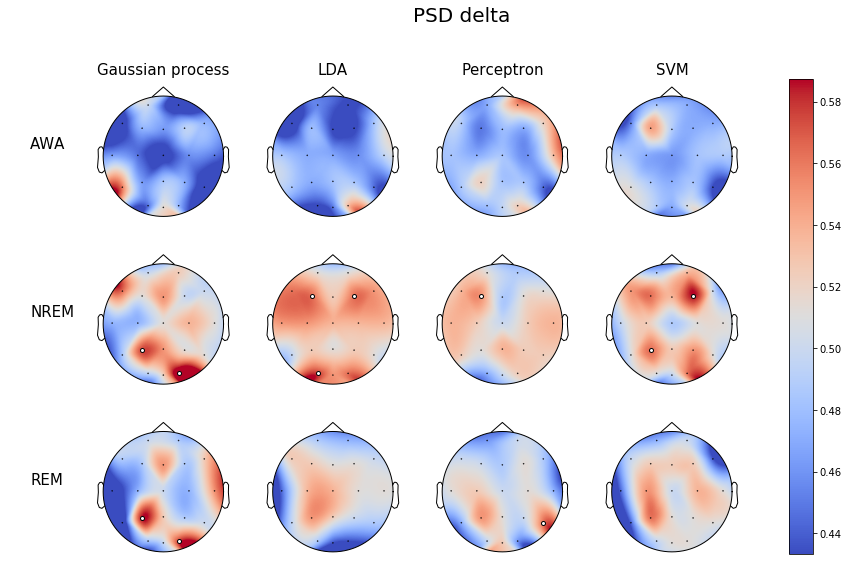

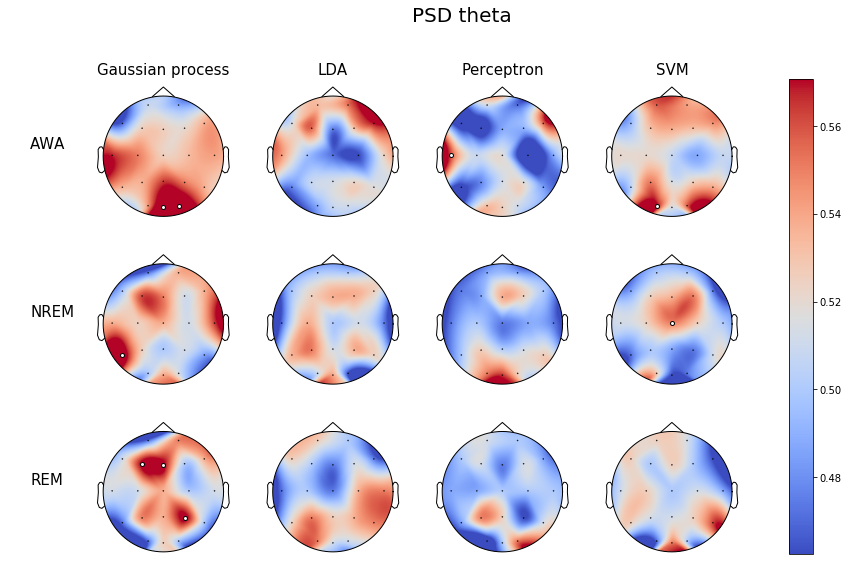

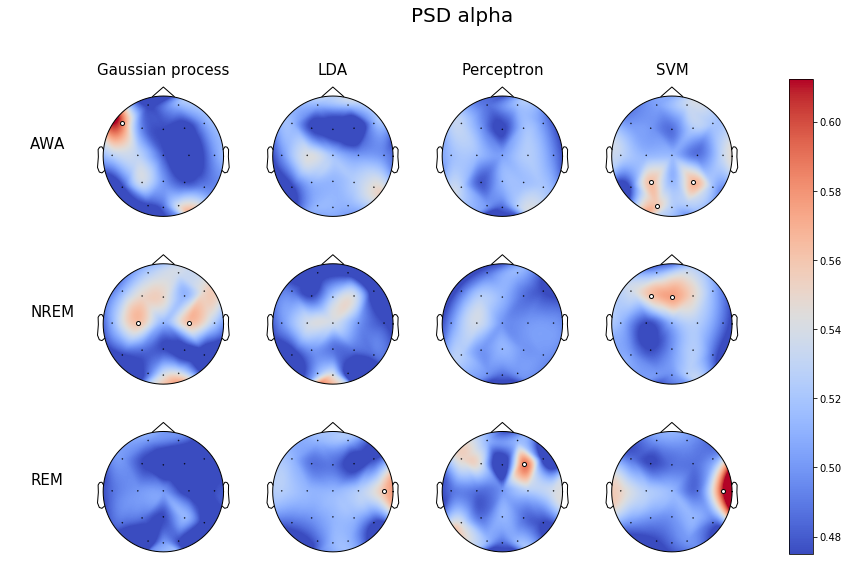

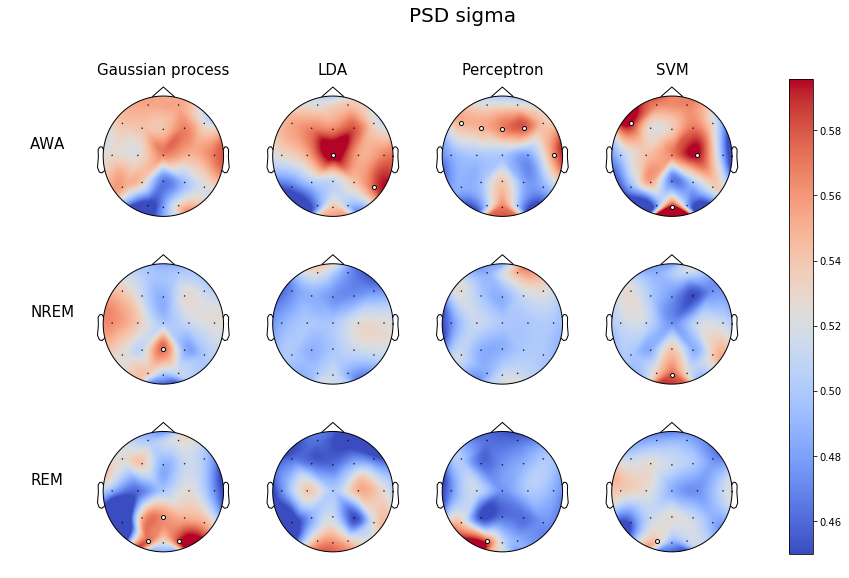

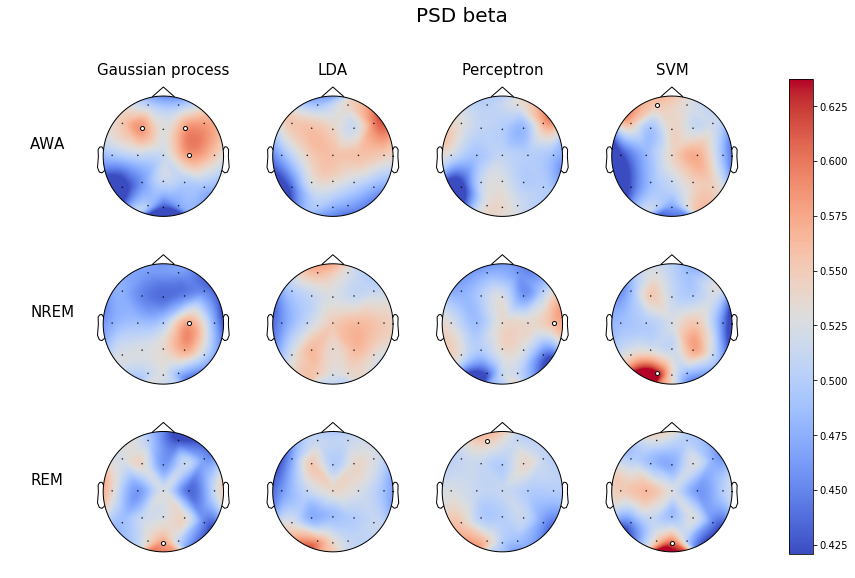

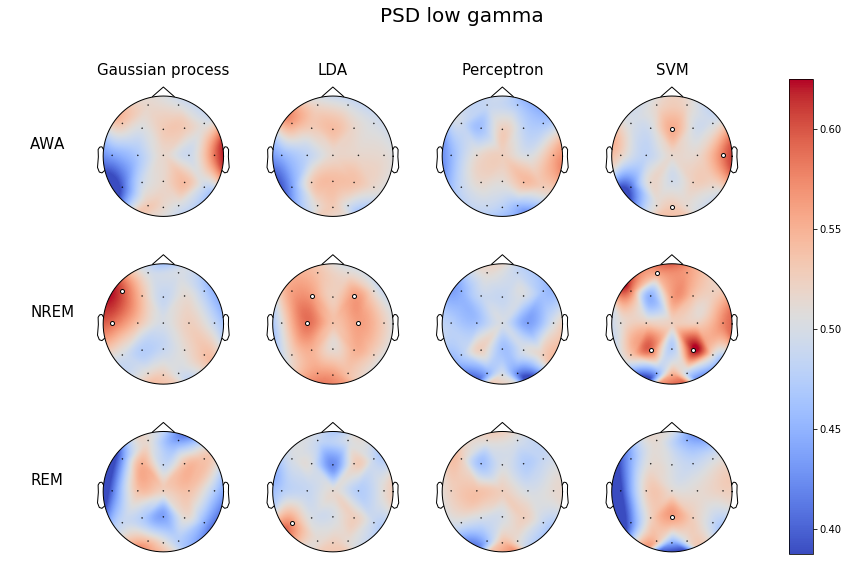

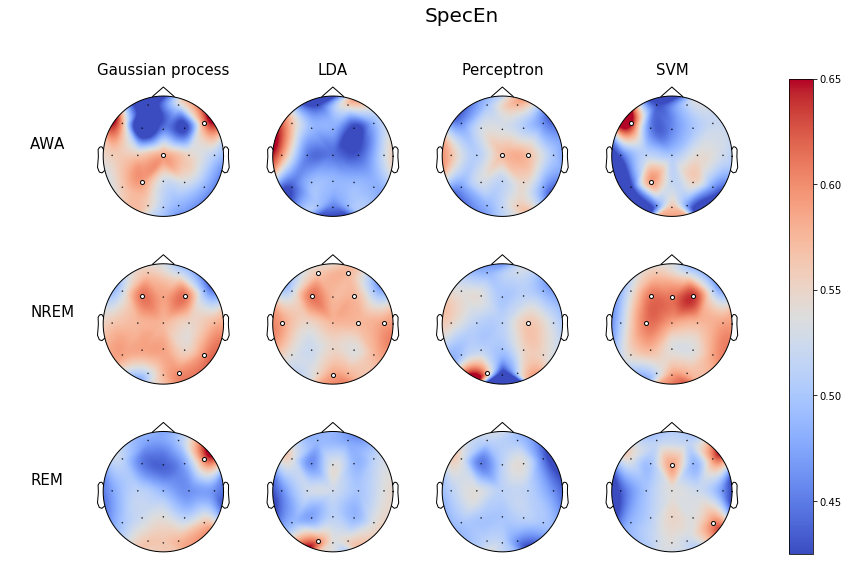

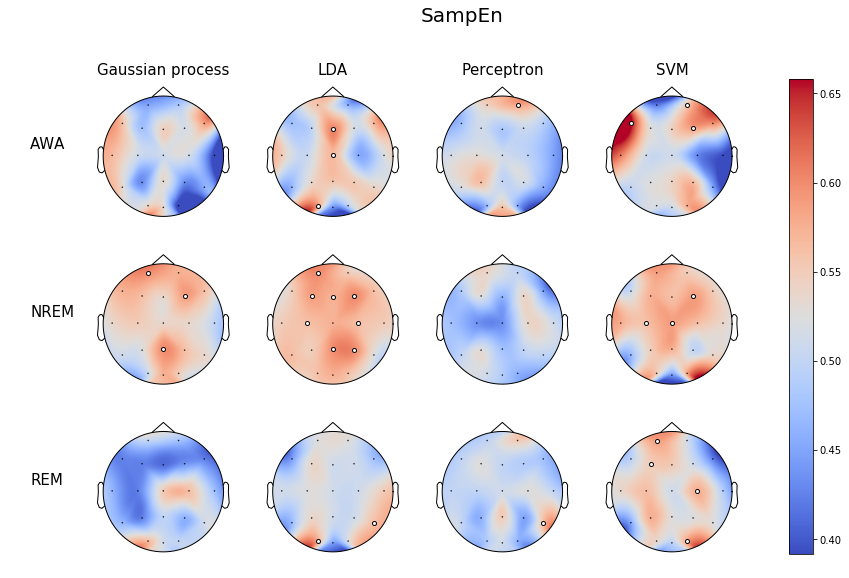

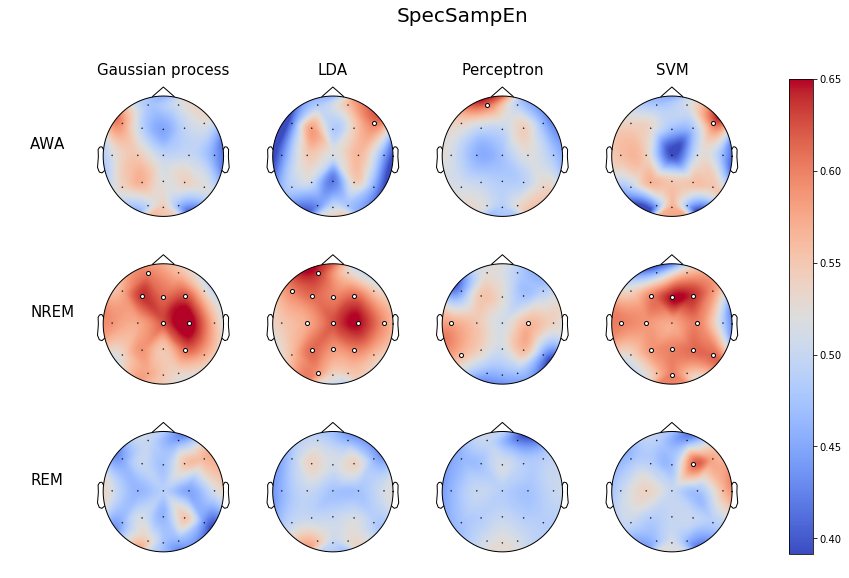

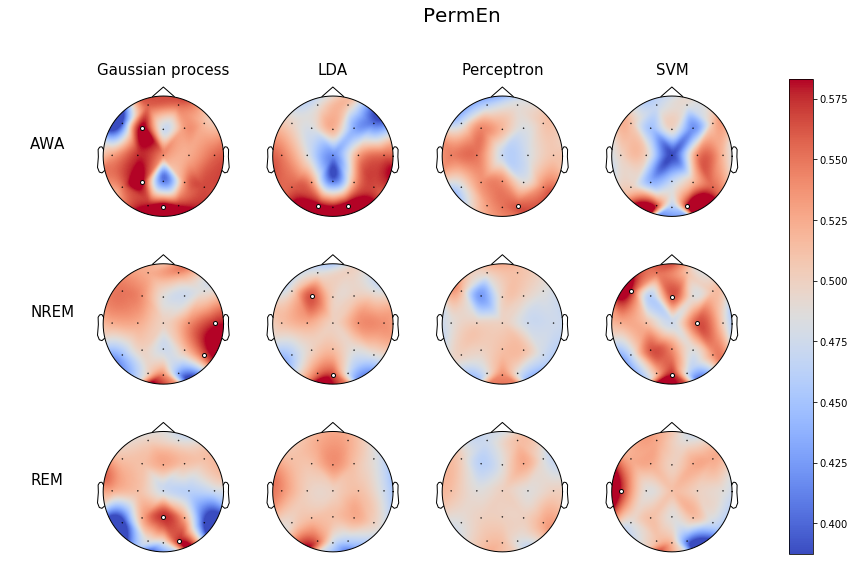

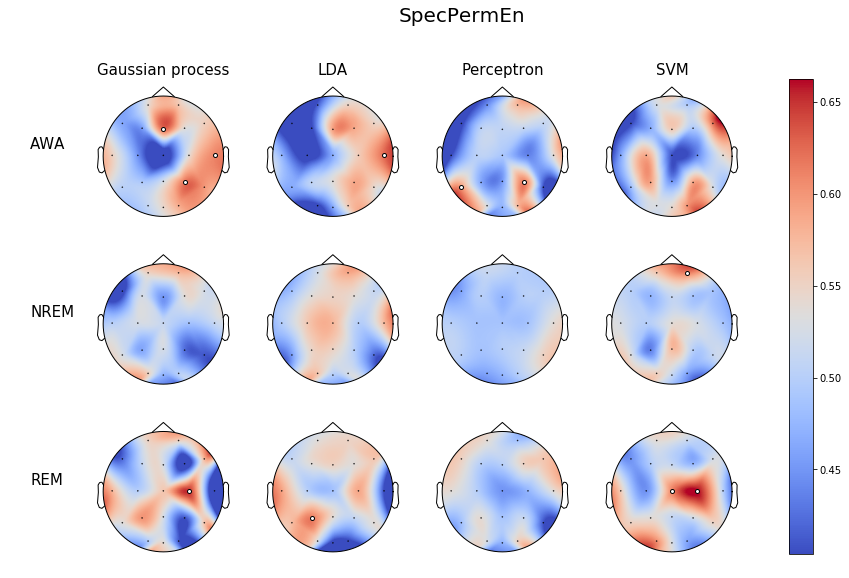

In [5]:
colormap = 'coolwarm'
small_font = 15
big_font = 20

for feature in scores[list(scores.keys())[0]][STAGES[0]].keys():
    vmin = np.min([[score[0] for score in scores[clf][stage][feature]] for stage in STAGES])
    vmax = np.max([[score[0] for score in scores[clf][stage][feature]] for stage in STAGES])
    
    plt.figure(figsize=(16, 8))
    plt.suptitle(feature.replace('_', ' ').replace('SpecShanEn', 'SpecEn'), fontsize=big_font, y=1.075)
    
    subplot_counter = 0
    gs = gridspec.GridSpec(len(STAGES), len(scores) + 1, width_ratios=[0.25] + [1] * len(scores))
    
    axes = []
    for stage in STAGES:
        axes.append(plt.subplot(gs[subplot_counter]))
        plt.annotate(stage.replace('AWSL', 'AWA'), xy=(0, 0.5), fontsize=small_font)
        plt.axis('off')
        subplot_counter += 1
        
        for clf in scores.keys():
            acc = [score[0] for score in scores[clf][stage][feature]]
            p_val = np.array([score[2] for score in scores[clf][stage][feature]])
            
            axes.append(plt.subplot(gs[subplot_counter]))
            if stage == STAGES[0]:
                plt.title(clf.replace('GaussianProcess', 'Gaussian process').replace('KNeighbors', 'k-NN'), fontsize=small_font)
            subplot_counter += 1
            
            mask = p_val < SIGNIFICANT_P
            viz.plot_topomap(acc, sensor_pos, mask=mask, vmin=vmin, vmax=vmax, cmap=colormap, contours=False, show=False)
    
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axes, shrink=1, aspect=20)
    plt.savefig(os.path.join(FIGURE_PATH, f'decodingAccuracySingle{CAF_DOSE}', f'decodingAccuracy_{feature}'))
    plt.show()